In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [2]:
raw = pd.read_csv('../dat/schools_w_clusters.csv')
raw = raw[['Cluster ID', 'Id', 'Site name', 'Address', 'Zip', 'Phone']]
raw['Zip'] = raw['Zip'].astype(str)
raw['Phone'] = raw['Phone'].astype(str)
raw.head(15)

,Cluster ID,Id,Site name,Address,Zip,Phone
0,0,0,salvation army - temple / salvation army,1 n ogden ave,nan,2262649.0
1,0,1,salvation army - temple / salvation army,1 n ogden ave,nan,2262649.0
2,0,215,salvation army temple,1 n. ogden,nan,2262649.0
3,0,509,salvation army - temple / salvation army,1 n ogden ave,nan,2262649.0
4,0,510,salvation army - temple / salvation army,1 n ogden ave,nan,2262649.0
5,0,1225,salvation army - temple / salvation army,1 n ogden ave,nan,2262649.0
6,0,1226,salvation army - temple / salvation army,1 n ogden ave,nan,2262649.0
7,0,1879,salvation army temple,1 n ogden,60640.0,2262649.0
8,0,2758,salvation army temple,1 n. ogden,60607.0,2262649.0
9,0,3255,salvation army - chicago temple corps communit...,1 n ogden avenue,60607.0,2262649.0


In [3]:
print('name max len =', raw['Site name'].str.len().max())
print('address max len =', raw['Address'].str.len().max())
print('Zip max len =', raw['Zip'].str.len().max())
print('phone max len =', raw['Phone'].str.len().max())

name max len = 95
address max len = 43
Zip max len = 7
phone max len = 9


for a total of max length 154

## defs
The following insanity is how we need to convert into a useable Torch tensor of correct size and Variable...ness.

In [4]:
Variable(torch.from_numpy(np.random.rand(10)).float()).view(1,10)

Variable containing:
 0.0181  0.5914  0.6572  0.6891  0.3115  0.8512  0.0298  0.4591  0.1530  0.7110
[torch.FloatTensor of size 1x10]

In [5]:
def extend_to_length(string_to_expand, length):
    extension = '~' * (length-len(string_to_expand))
    return string_to_expand + extension

def record_formatter(record):
    name = extend_to_length(record['Site name'], 95)
    addr = extend_to_length(record['Address'], 43)
    zipp = extend_to_length(record['Zip'], 7)
    phon = extend_to_length(record['Phone'], 9)
    
    strings = list(''.join((name, addr, zipp, phon)))
    characters = np.array(list(map(ord, strings)))
    
    return Variable(torch.from_numpy(characters).float()).view(1,len(characters))

In [131]:
class SiameseNetwork(nn.Module):
    def __init__(self, v_size=154, enc_size=50):
        super(SiameseNetwork, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(v_size, 400),
            nn.ReLU(True),
            nn.Linear(400, 200),
            nn.ReLU(True),
            nn.Linear(200, 100),
            nn.ReLU(True),
            nn.Linear(100, enc_size)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(enc_size, 75),
            nn.ReLU(True),
            nn.Linear(75, 100),
            nn.ReLU(True),
            nn.Linear(100, 125),
            nn.ReLU(True),
            nn.Linear(125, v_size)
        )
        
        self.discriminator = nn.Sequential(
            nn.Linear(enc_size*2, 100),
            nn.ReLU(True),
            nn.Linear(100, 50),
            nn.ReLU(True),
            nn.Linear(50,2),
            nn.LogSoftmax()
        )

    def discriminate(self, input1, input2):
        output = self.discriminator(torch.cat([input1, input2], dim=1))
        return output
    
    def autoencode(self, vector):
        return self.decoder(self.encoder(vector))
    
    def encode(self, vector):
        return self.encoder(vector)

## data characteristics

In [7]:
raw.shape

(2693, 6)

In [8]:
raw['Cluster ID'].unique().shape

(740,)

## training

In [167]:
learning_rate = 0.001

model = SiameseNetwork()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [170]:
%%time
ae_loss = []

model.train()

# train autoencoder
for epoch in range(1):
    temp_loss = 0
    
    for i in range(raw.shape[0]):
        # build data pairs
        inpt = record_formatter(raw.iloc[i])

        # forward
        otpt = model.autoencode(inpt)
        loss = criterion(otpt, inpt)
        
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # logging
        temp_loss += loss

    # logging
    ae_loss.append(temp_loss.data[0]/raw.shape[0])

CPU times: user 3min 4s, sys: 8.05 s, total: 3min 12s
Wall time: 28.1 s


In [173]:
criterion = nn.NLLLoss()

In [174]:
%%time

disc_loss = []
diff = 1
model.train()

# train discriminator
for epoch in range(1):
    temp_loss = 0
    
    for i in range(raw.shape[0]-diff):
        # build data pairs
        inpt1 = model.encode(record_formatter(raw.iloc[i]))
        inpt2 = model.encode(record_formatter(raw.iloc[i+diff]))
        label = 1 if (raw.iloc[i]['Cluster ID'] == raw.iloc[i+diff]['Cluster ID']) else 0
        label = Variable(torch.LongTensor([label]))
        
        # forward
        otpt = model.discriminate(inpt1, inpt2)
        loss = criterion(otpt, label)
        
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # logging
        temp_loss += loss

    # logging
    disc_loss.append(temp_loss.data[0]/raw.shape[0])

CPU times: user 3min 7s, sys: 5min 26s, total: 8min 34s
Wall time: 1min 5s


Don't forget to Exp the output b/c LogSoftmax

In [175]:
torch.exp(model.discriminate(inpt1, inpt2))

Variable containing:
 0.4388  0.5612
[torch.FloatTensor of size 1x2]

In [176]:
print('ae loss =', ae_loss)
print('disc ls =', disc_loss)

ae loss = [314.7897326401782]
disc ls = [315.39150111399925]


In [124]:
inpt1 = model.encode(record_formatter(raw.iloc[0]))
inpt2 = model.encode(record_formatter(raw.iloc[4]))

model.discriminate(inpt1, inpt2)

Variable containing:
 2.3750e-13  1.0000e+00
[torch.FloatTensor of size 1x2]

In [79]:
model.eval()

SiameseNetwork (
  (encoder): Sequential (
    (0): Linear (154 -> 400)
    (1): ReLU (inplace)
    (2): Linear (400 -> 200)
    (3): ReLU (inplace)
    (4): Linear (200 -> 100)
    (5): ReLU (inplace)
    (6): Linear (100 -> 50)
  )
  (decoder): Sequential (
    (0): Linear (50 -> 75)
    (1): ReLU (inplace)
    (2): Linear (75 -> 100)
    (3): ReLU (inplace)
    (4): Linear (100 -> 125)
    (5): ReLU (inplace)
    (6): Linear (125 -> 154)
  )
  (discriminator): Sequential (
    (0): Linear (100 -> 100)
    (1): ReLU (inplace)
    (2): Linear (100 -> 50)
    (3): ReLU (inplace)
    (4): Linear (50 -> 2)
    (5): Softmax ()
  )
)

In [75]:
model.state_dict().keys()

odict_keys(['fc1.0.weight', 'fc1.0.bias', 'fc1.2.weight', 'fc1.2.bias'])

In [12]:
inpt1.size()

torch.Size([1, 154])

In [13]:
loss_calc

Variable containing:
nan
[torch.FloatTensor of size 1]

In [14]:
model.forward(inpt1,inpt2)

(Variable containing:
 
 Columns 0 to 12 
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
 
 Columns 13 to 25 
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
 
 Columns 26 to 38 
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
 
 Columns 39 to 51 
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
 
 Columns 52 to 64 
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
 
 Columns 65 to 77 
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
 
 Columns 78 to 79 
   nan   nan
 [torch.FloatTensor of size 1x80], Variable containing:
 
 Columns 0 to 12 
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
 
 Columns 13 to 25 
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
 
 Columns 26 to 38 
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   

In [14]:
plt.plot(loss_holder)
plt.show()

ValueError: x and y can be no greater than 2-D, but have shapes (1,) and (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)

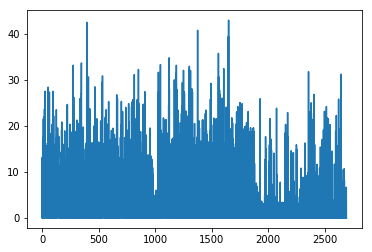

In [53]:
plt.plot(loss_holder[:raw.shape[0]])
plt.show()

In [16]:
model.state_dict()

OrderedDict([('fc1.0.weight', 
              1.00000e-02 *
                  nan     nan     nan  ...      nan     nan     nan
               7.3819 -4.0287 -6.9461  ...   6.9727  2.0407 -6.6162
                  nan     nan     nan  ...      nan     nan     nan
                        ...             ⋱             ...          
                  nan     nan     nan  ...      nan     nan     nan
                  nan     nan     nan  ...      nan     nan     nan
                  nan     nan     nan  ...      nan     nan     nan
              [torch.FloatTensor of size 100x154]), ('fc1.0.bias', 
              1.00000e-02 *
                   nan
               -0.4525
                   nan
                6.7199
                   nan
                   nan
                   nan
                   nan
                   nan
                   nan
                   nan
                   nan
                   nan
                   nan
                   nan
               -0.6064
 